# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.plotting import plot_histograms


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        # print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')
# limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

19:11 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
19:11 madminer.analysis    INFO    Found 2 parameters
19:11 madminer.analysis    INFO    Did not find nuisance parameters
19:11 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
19:11 madminer.analysis    INFO    Found 3 observables
19:11 madminer.analysis    INFO    Found 89991 events
19:11 madminer.analysis    INFO      49991 signal events sampled from benchmark sm
19:11 madminer.analysis    INFO      10000 signal events sampled from benchmark w
19:11 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
19:11 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
19:11 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
19:11 madminer.analysis    INFO    Found morphing setup with 6 components
19:11 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [25, 25]

What luminosity (in inverse pb) are we talking about?

In [5]:
lumi = 300.*1000. 

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [6]:
## create dictionaries to store results
p_values = {}
mle = {}

In [7]:
try:
    theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, (histos, observed, observed_weights) = limits.expected_limits(
        mode="histo",
        hist_vars=["pt_j1"],
        theta_true=[0.,0.],
        grid_ranges=grid_ranges,
        grid_resolutions=grid_resolutions,
        luminosity=lumi,
        include_xsec=False,
        return_asimov=True,
    )

    p_values["Histogram"] = p_values_expected_histo
    mle["Histogram"] = best_fit_expected_histo
except: 
    print("no Histogram")

19:11 madminer.limits      INFO    Generating Asimov data
19:11 madminer.limits      INFO    Expected events: 296.8608606876634
19:11 madminer.limits      INFO    Calculating p-values for 296.8608606876634 expected events in mode histo without rate information
19:11 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:11 madminer.limits      INFO    Setting up standard summary statistics
19:11 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using (25,) bins each, or 25 in total.
19:11 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
19:11 madminer.analysis    WARNING Requested 100000 events, but only 71993 available
19:11 madminer.analysis    WARNING Requested 100000 events, but only 71993 available
19:11 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
19:11 madminer.limits      INFO    Calculating p-values


With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

Let's visualize the likelihood estimated with these histograms:

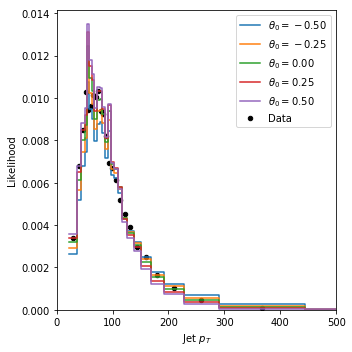

In [8]:
indices = [12 + i * 25 for i in [6,9,12,15,18]]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=[observed[i] for i in indices],
    observed_weights=observed_weights,
    histo_labels=[r"$\theta_0 = {:.2f}$".format(theta_grid[i,0]) for i in indices],
    xlabel="Jet $p_T$",
    xrange=(0.,500.),
)

plt.show()


## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [9]:
try:
    theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
        mode="ml",
        model_file='models/alices',
        theta_true=[0.,0.],
        grid_ranges=grid_ranges,
        grid_resolutions=grid_resolutions,
        luminosity=lumi,
        include_xsec=False,
    )

    p_values["ALICES"] = p_values_expected_alices
    mle["ALICES"] = best_fit_expected_alices
except:
    print("no ALICES")

19:11 madminer.limits      INFO    Generating Asimov data
19:11 madminer.limits      INFO    Expected events: 296.8608606876634
19:11 madminer.limits      INFO    Calculating p-values for 296.8608606876634 expected events in mode ml without rate information
19:11 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:11 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
19:11 madminer.ml          INFO    Loading model from models/alices
19:11 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
19:11 madminer.ml          INFO    Loading evaluation data
19:11 madminer.ml          INFO    Starting ratio evaluation for 6310625 x-theta combinations
19:13 madminer.ml          INFO    Evaluation done
19:13 madminer.limits      INFO    Calculating p-values


and the ALICES estimator which only used the observable `pt_j1`

In [10]:
try:
    theta_grid, p_values_expected_alices_pt, best_fit_expected_alices_pt, _, _, _ = limits.expected_limits(
        mode="ml",
        model_file='models/alices_pt',
        theta_true=[0.,0.],
        grid_ranges=grid_ranges,
        grid_resolutions=grid_resolutions,
        luminosity=lumi,
        include_xsec=False,
    )

    p_values["ALICES_pt"] = p_values_expected_alices_pt
    mle["ALICES_pt"] = best_fit_expected_alices_pt
except:
    print("no ALICES_pt")

19:13 madminer.limits      INFO    Generating Asimov data
19:13 madminer.limits      INFO    Expected events: 296.8608606876634
19:13 madminer.limits      INFO    Calculating p-values for 296.8608606876634 expected events in mode ml without rate information
19:13 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:13 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
19:13 madminer.ml          INFO    Loading model from models/alices_pt
19:13 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
19:13 madminer.ml          INFO    Loading evaluation data
19:13 madminer.ml          INFO    Starting ratio evaluation for 6310625 x-theta combinations
19:16 madminer.ml          INFO    Evaluation done
19:16 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [11]:
try:
    theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, (histos, observed, observed_weights) = limits.expected_limits(
        mode="sally",
        model_file='models/sally',
        theta_true=[0.,0.],
        grid_ranges=grid_ranges,
        grid_resolutions=grid_resolutions,
        luminosity=lumi,
        include_xsec=False,
        return_asimov=True,
    )
    p_values["SALLY"] = p_values_expected_sally
    mle["SALLY"] = best_fit_expected_sally
except: 
    print("no SALLY")

19:16 madminer.limits      INFO    Generating Asimov data
19:16 madminer.limits      INFO    Expected events: 296.8608606876634
19:16 madminer.limits      INFO    Calculating p-values for 296.8608606876634 expected events in mode sally without rate information
19:16 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:16 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics


no SALLY


Let's have a look at the underlying 2D histograms:

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


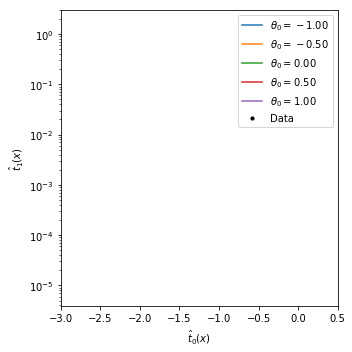

In [12]:
indices = [12 + i * 25 for i in [0,6,12,18,24]]

fig = plot_histograms(
    histos=[histos[i] for i in indices],
    observed=observed[0,:100,:],
    observed_weights=observed_weights[:100],
    histo_labels=[r"$\theta_0 = {:.2f}$".format(theta_grid[i,0]) for i in indices],
    xlabel=r'$\hat{t}_0(x)$',
    ylabel=r'$\hat{t}_1(x)$',
    xrange=(-3.,.5),
    yrange=(-3.,3.),
    log=True,
    zrange=(1.e-3,1.),
    markersize=10.
)
    

## 5. Expected limits based on likelihood estimators

In [13]:
try:
    theta_grid, p_values_expected_scandal, best_fit_expected_scandal, _, _, _ = limits.expected_limits(
        mode="ml",
        model_file='models/scandal',
        theta_true=[0.,0.],
        grid_ranges=grid_ranges,
        grid_resolutions=grid_resolutions,
        luminosity=lumi,
        include_xsec=False,
    )

    p_values["SCANDAL"] = p_values_expected_scandal
    mle["SCANDAL"] = best_fit_expected_scandal
except:
    print("no SCANDAL")

19:16 madminer.limits      INFO    Generating Asimov data
19:16 madminer.limits      INFO    Expected events: 296.8608606876634
19:16 madminer.limits      INFO    Calculating p-values for 296.8608606876634 expected events in mode ml without rate information
19:16 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:16 madminer.limits      INFO    Loading kinematic likelihood ratio estimator


no SCANDAL


## 6. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [14]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
x_observed, _, _ = sampler.sample_test(
    theta=sampling.morphing_point([0.5,0.5]),
    n_samples=100,
    folder=None,
    filename=None,
)

19:16 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
19:16 madminer.analysis    INFO    Found 2 parameters
19:16 madminer.analysis    INFO    Did not find nuisance parameters
19:16 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
19:16 madminer.analysis    INFO    Found 3 observables
19:16 madminer.analysis    INFO    Found 89991 events
19:16 madminer.analysis    INFO      49991 signal events sampled from benchmark sm
19:16 madminer.analysis    INFO      10000 signal events sampled from benchmark w
19:16 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
19:16 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
19:16 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
19:16 madminer.analysis    INFO    Found morphing setup with 6 components
19:16 madminer.analysis    INFO    Did not find nuisance morphing setup
19:16 madminer.sampling    INFO    Extracting ev

In [15]:
_, p_values_observed, best_fit_observed, _, _, _ = limits.observed_limits(
    x_observed=x_observed,
    mode="ml",
    model_file='models/alices',
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES (observed)"] = p_values_observed
mle["ALICES (observed)"] = best_fit_observed

19:16 madminer.limits      INFO    Calculating p-values for 100 expected events in mode ml without rate information
19:16 madminer.limits      INFO    Evaluating likelihood on a regular grid with 625 parameter points
19:16 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
19:16 madminer.ml          INFO    Loading model from models/alices
19:16 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
19:16 madminer.ml          INFO    Loading evaluation data
19:16 madminer.ml          INFO    Starting ratio evaluation for 62500 x-theta combinations
19:16 madminer.ml          INFO    Evaluation done
19:16 madminer.limits      INFO    Calculating p-values


## 7. Plot

Let's plot the results:

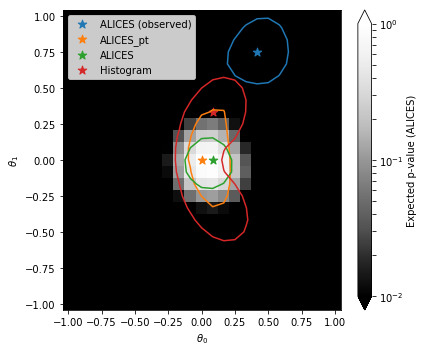

In [16]:
show = "ALICES"

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-2, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((grid_resolutions[0], grid_resolutions[1])).T,
        levels=[0.32],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()


### Save results

Let's save the results to later compare them to results obtained in other notebooks. 

In [17]:
np.save("limits/limits.npy", [p_values,mle])